In [1]:
import time
import copy
import torch
import torchvision
import sklearn.model_selection
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
torch.cuda

<module 'torch.cuda' from '/home/robot/.local/lib/python3.5/site-packages/torch/cuda/__init__.py'>

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [4]:
PATH_OF_DATA = "/media/robot/097DBCB36A40A41A/shyngys/FINALLY_SEPARATED/camera2"
# !ls {PATH_OF_DATA}
# /media/robot/097DBCB36A40A41A/shyngys/FINALLY_SEPARATED

print(PATH_OF_DATA)

/media/robot/097DBCB36A40A41A/shyngys/FINALLY_SEPARATED/camera2


In [5]:
full_data_set = torchvision.datasets.ImageFolder(root = PATH_OF_DATA)
classes = full_data_set.classes

print(classes)

['Bottom', 'Center Stack', 'Instrument Cluster', 'Left', 'Rearview Mirror', 'Right', 'Road']


In [6]:
data_transforms = {
    "train":
        torchvision.transforms.Compose([
                    torchvision.transforms.Resize((224, 224)),
#                     torchvision.transforms.ColorJitter(brightness=0.2, saturation=0.1),
#                     torchvision.transforms.RandomHorizontalFlip(p = 1),
                    torchvision.transforms.RandomRotation(degrees=10),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
    "val":
        torchvision.transforms.Compose([ 
                    torchvision.transforms.Resize((224, 224)),
#                     torchvision.transforms.ColorJitter(brightness=0.2, saturation=0.1),
#                     torchvision.transforms.RandomHorizontalFlip(p = 1),
                    torchvision.transforms.RandomRotation(degrees=10),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
    "test":
        torchvision.transforms.Compose([ 
                    torchvision.transforms.Resize((224, 224)),
#                     torchvision.transforms.ColorJitter(brightness=0.2, saturation=0.1),
#                     torchvision.transforms.RandomHorizontalFlip(p = 1),
                    torchvision.transforms.RandomRotation(degrees=10),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])    
}

In [7]:
print('Total number of images: ', len(full_data_set))

Total number of images:  9882


In [8]:
class CustomDataset(torchvision.datasets.ImageFolder):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

In [9]:
VALIDATION_FRACTION = 1/10
TRAIN_FRACTION = 4/5

train_size = int(TRAIN_FRACTION * len(full_data_set))
val_size = int(VALIDATION_FRACTION * len(full_data_set))
test_size = len(full_data_set) - train_size - val_size
train_subset, val_subset, test_subset = torch.utils.data.random_split(full_data_set, [train_size, val_size, test_size])

In [10]:
train_dataset = CustomDataset(
    train_subset, transform=data_transforms["train"]
)
val_dataset = CustomDataset(
    val_subset, transform=data_transforms["val"]
)
test_dataset = CustomDataset(
    test_subset, transform=data_transforms["test"]
)

In [11]:
BATCH_SIZE = 64
NUM_WORKERS = 4

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                                           num_workers=NUM_WORKERS)

validation_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, 
                                           num_workers=NUM_WORKERS)

test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, 
                                          num_workers=NUM_WORKERS, 
                                          shuffle=True)

In [12]:
dataloaders = {
    'train': train_data_loader,
    'val': validation_data_loader,
    'test': test_data_loader
};

In [13]:
dataset_sizes = {
    "train": len(train_data_loader.dataset),
    "val": len(validation_data_loader.dataset),
    "test": len(test_data_loader.dataset)
}

print('Num training images: ', dataset_sizes["train"])
print('Num validation images: ', dataset_sizes["val"])
print('Num test images: ', dataset_sizes["test"])

Num training images:  7905
Num validation images:  988
Num test images:  989


VISUALIZATION


In [14]:
dataiter = iter(train_data_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

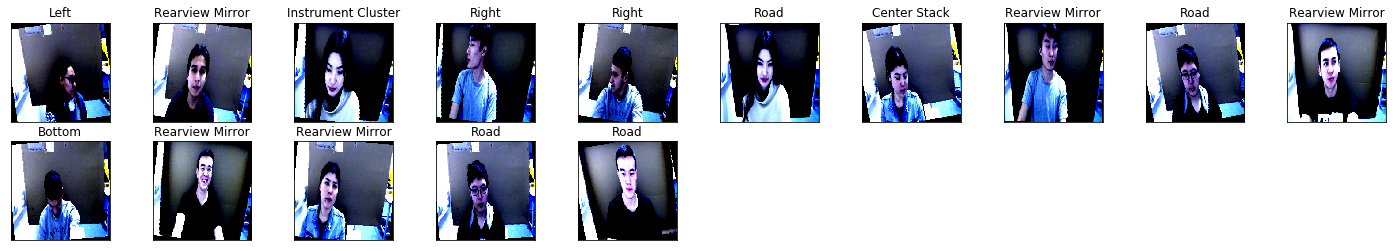

In [15]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(15):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0))) # np transpose to convert tensor to image
    ax.set_title(classes[labels[idx]])

**THIS IS WHERE LEARNING BEGINS**

In [16]:
# resnet = torchvision.models.resnet50(pretrained = True)

# # Freeze weights
# for param in resnet.parameters():
#     param.requires_grad = False
    
# features_num = resnet.fc.in_features

# resnet.fc = torch.nn.Sequential(
#     torch.nn.Linear(features_num, 1024),
#     torch.nn.ReLU(inplace=True),
#     torch.nn.Linear(1024, 512),
#     torch.nn.ReLU(inplace=True),
#     torch.nn.Linear(512, len(classes))
# )

# for param in resnet.parameters():
#     print(param.requires_grad)

In [22]:
model = torchvision.models.resnet50(pretrained = True)

# Freeze weights
# for param in model.parameters():
#     param.requires_grad = False

ct = 0
for child in model.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

features_num = model.fc.in_features

            
model.fc = torch.nn.Sequential(
    torch.nn.Linear(features_num, 1024),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(inplace=True),
    torch.nn.Linear(512, len(classes))
)

model = torch.nn.DataParallel(model)
# model.load_state_dict(torch.load('/content/drive/My Drive/driver_dataset/models/resnet_final_model_2.pth'))
# model.cuda()
# model.eval()

model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [17]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.module.fc.parameters(), lr=0.001, momentum=0.9)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [18]:
def train_model(model, criterion, optimizer, num_epochs=3):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc)
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc)

            print('{} - Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), './models/resnet_final_model_conv_freeze.pth')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    
    results= {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accs": train_accs,
        "val_accs": val_accs
    }
    return model, copy.deepcopy(results)

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [20]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [21]:
model.to(device)
model = torch.nn.DataParallel(model)

model_ft, results = train_model(model, criterion, optimizer,
                       num_epochs=24)

Epoch 0/23
----------
train - Loss: 1.8282 Acc: 0.3259
val - Loss: 1.7928 Acc: 0.3391

Epoch 1/23
----------
train - Loss: 1.7628 Acc: 0.3448
val - Loss: 1.7405 Acc: 0.3391

Epoch 2/23
----------
train - Loss: 1.6799 Acc: 0.3695
val - Loss: 1.6272 Acc: 0.4160

Epoch 3/23
----------
train - Loss: 1.5373 Acc: 0.4434
val - Loss: 1.4668 Acc: 0.4646

Epoch 4/23
----------
train - Loss: 1.3889 Acc: 0.4994
val - Loss: 1.3437 Acc: 0.5091

Epoch 5/23
----------
train - Loss: 1.2799 Acc: 0.5386
val - Loss: 1.2494 Acc: 0.5334

Epoch 6/23
----------
train - Loss: 1.1944 Acc: 0.5704
val - Loss: 1.1694 Acc: 0.5658

Epoch 7/23
----------
train - Loss: 1.1233 Acc: 0.5934
val - Loss: 1.1070 Acc: 0.5840

Epoch 8/23
----------
train - Loss: 1.0679 Acc: 0.6106
val - Loss: 1.0633 Acc: 0.6053

Epoch 9/23
----------
train - Loss: 1.0038 Acc: 0.6336
val - Loss: 0.9908 Acc: 0.6164

Epoch 10/23
----------
train - Loss: 0.9463 Acc: 0.6659
val - Loss: 0.9539 Acc: 0.6488

Epoch 11/23
----------
train - Loss: 0.905

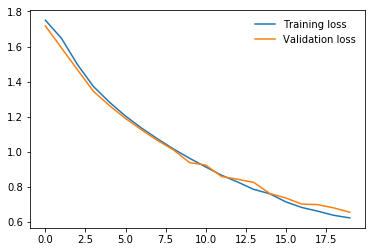

In [28]:
plt.plot(results['train_losses'], label='Training loss')
plt.plot(results['val_losses'], label='Validation loss')
plt.legend(frameon=False)
plt.show()

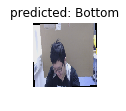

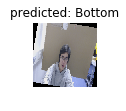

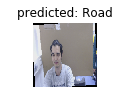

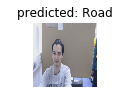

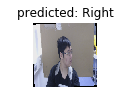

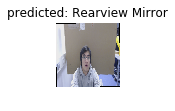

In [30]:
plt.ion()
visualize_model(model_ft)

plt.ioff()
plt.show()

LOADING MODEL


In [33]:
def test(test_model):   
    criterion = torch.nn.CrossEntropyLoss()
    # track test loss
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    test_model.to(device)
    test_model.eval()
    # iterate over test data
    for data, target in dataloaders['test']:
        # move tensors to GPU if CUDA is available
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = test_model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update test loss 
        test_loss += loss.item() * data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)    
        # compare predictions to true label
        correct_tensor = pred.eq(target.data.view_as(pred))
        correct = (
                 np.squeeze(correct_tensor.cpu().numpy()))
        # calculate test accuracy for each object class
        for i in range(BATCH_SIZE):
            if (i < len(target.data)):
                label = target.data[i]
                if (label < len(class_correct)):
    #                 print(correct[i])
                    class_correct[label] += correct[i].item()
                    class_total[label] += 1

    # average test loss
    test_loss = test_loss/len(dataloaders['test'].dataset)
    print('Test Loss: {:.6f}\n'.format(test_loss))

    for i in range(7):
        if class_total[i] > 0:
            print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
                classes[i], 100 * class_correct[i] / class_total[i],
                np.sum(class_correct[i]), np.sum(class_total[i])))
        else:
            print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

    print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
        100. * np.sum(class_correct) / np.sum(class_total),
        np.sum(class_correct), np.sum(class_total)))

In [34]:
# test(model)
test(model_ft)

Test Loss: 0.607310

Test Accuracy of Bottom: 95% (123/129)
Test Accuracy of Center Stack: 80% (82/102)
Test Accuracy of Instrument Cluster: 48% (54/111)
Test Accuracy of  Left: 75% (75/100)
Test Accuracy of Rearview Mirror: 86% (92/106)
Test Accuracy of Right: 85% (82/96)
Test Accuracy of  Road: 84% (292/345)

Test Accuracy (Overall): 80% (800/989)


In [35]:
nb_classes = 7

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, target) in enumerate(dataloaders['val']):
        print (target)
        inputs = inputs.to(device)
        target = target.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(target.view(-1), preds.view(-1)):
            #print ((t.long(), p.long())) 
            confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([0, 6, 6, 6, 3, 4, 3, 4, 6, 5, 6, 1, 1, 6, 3, 2, 6, 3, 6, 0, 0, 3, 0, 6,
        0, 6, 2, 0, 4, 6, 5, 6, 6, 3, 6, 6, 6, 6, 6, 0, 1, 5, 6, 6, 0, 2, 6, 5,
        0, 0, 4, 6, 6, 4, 6, 0, 6, 0, 6, 6, 1, 2, 3, 0])
tensor([4, 2, 5, 4, 0, 0, 2, 3, 2, 4, 0, 0, 1, 5, 3, 4, 6, 1, 2, 4, 6, 5, 6, 6,
        6, 2, 0, 6, 6, 1, 6, 2, 6, 4, 2, 1, 5, 3, 5, 6, 1, 1, 6, 6, 3, 6, 6, 2,
        1, 0, 2, 6, 0, 6, 6, 6, 5, 5, 4, 0, 1, 0, 2, 3])
tensor([3, 5, 5, 5, 6, 2, 2, 1, 0, 1, 5, 0, 1, 1, 3, 6, 6, 6, 6, 6, 3, 3, 2, 3,
        4, 6, 6, 3, 2, 2, 6, 4, 5, 3, 4, 1, 2, 6, 6, 4, 6, 3, 2, 1, 1, 0, 1, 6,
        6, 3, 6, 6, 2, 6, 6, 1, 6, 2, 2, 6, 0, 6, 3, 6])
tensor([5, 2, 0, 0, 2, 1, 6, 2, 1, 3, 2, 2, 4, 6, 6, 2, 4, 1, 1, 0, 3, 6, 2, 6,
        6, 5, 4, 6, 6, 2, 4, 1, 4, 3, 6, 0, 6, 6, 6, 0, 6, 5, 2, 3, 2, 5, 1, 5,
        6, 3, 1, 6, 6, 5, 0, 2, 6, 6, 0, 6, 6, 6, 0, 1])
tensor([3, 6, 2, 4, 0, 0, 6, 6, 1, 0, 2, 6, 5, 2, 4, 6, 3, 4, 3, 0, 6, 6, 2, 1,
        1, 1, 6, 6, 0, 4, 6, 3, 1, 2, 0, 0, 1, 3, 1,

In [36]:
print(confusion_matrix.diag()/confusion_matrix.sum(1))

tensor([0.8571, 0.7500, 0.5041, 0.6809, 0.9189, 0.8085, 0.8388])


In [37]:
conf_numpy = confusion_matrix.cpu().numpy()

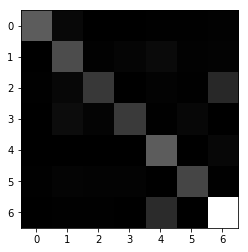

In [38]:
plt.imshow(conf_numpy, cmap='gray')
plt.show()